In [1]:
from py2neo import Graph, Node, Relationship
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Connect to graph
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password")) 

In [49]:
# Retrieve all tweets mentioning candidates
query = """\
MATCH p= (c:Candidate)<-[]-(t:Tweet)
WHERE exists(t.sentiment) AND not (t.text =~ 'RT.*' OR t.extended_tweet =~ 'RT.*')
return t.created_at as time, c.name as candidate, t.sentiment as sentiment
"""
s_df=graph.run(query).to_data_frame()

In [50]:
# Neo4J doesn't store floats, convert the string here
s_df['sentiment']=s_df['sentiment'].apply(float)

In [51]:
# Add DateTimeIndex to DataFrame
s_df.set_index(pd.to_datetime(s_df['time']),inplace=True)

In [52]:
# Make sure things look alright
s_df.head()

,candidate,sentiment,time
time,,,
2019-06-28 15:08:11,Andrew Yang,-0.3919,Fri Jun 28 15:08:11 +0000 2019
2019-06-28 15:08:05,Andrew Yang,0.7644,Fri Jun 28 15:08:05 +0000 2019
2019-06-28 15:03:22,Andrew Yang,-0.5067,Fri Jun 28 15:03:22 +0000 2019
2019-06-28 15:03:14,Andrew Yang,0.7959,Fri Jun 28 15:03:14 +0000 2019
2019-06-28 15:03:08,Andrew Yang,0.3054,Fri Jun 28 15:03:08 +0000 2019


In [7]:
# Set up analysis boundaries
before_debate = pd.to_datetime('2019-06-26 12:00:00')
after_debate = pd.to_datetime('2019-06-28 08:00:00')

## Sentiment Analysis
Determein

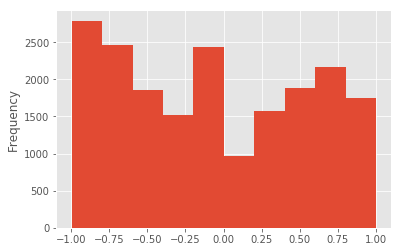

In [53]:
# Check out sentiment distribution as a baseline
s_df.sentiment.plot(kind='hist')

In [54]:
# Create categorical variables for sentiment
bins=[-1,-.25,.25,1]
labels=['negative','neutral','positive']
s_df['sentiment_cat']=pd.cut(s_df.sentiment,bins=bins,labels=labels)

In [55]:
# Add new variables to DataFrame
s_df = pd.concat([s_df,pd.get_dummies(s_df.sentiment_cat)],axis=1)

In [56]:
# Make sure everything is still alright
s_df.head()

,candidate,sentiment,time,sentiment_cat,negative,neutral,positive
time,,,,,,,
2019-06-28 15:08:11,Andrew Yang,-0.3919,Fri Jun 28 15:08:11 +0000 2019,negative,1,0,0
2019-06-28 15:08:05,Andrew Yang,0.7644,Fri Jun 28 15:08:05 +0000 2019,positive,0,0,1
2019-06-28 15:03:22,Andrew Yang,-0.5067,Fri Jun 28 15:03:22 +0000 2019,negative,1,0,0
2019-06-28 15:03:14,Andrew Yang,0.7959,Fri Jun 28 15:03:14 +0000 2019,positive,0,0,1
2019-06-28 15:03:08,Andrew Yang,0.3054,Fri Jun 28 15:03:08 +0000 2019,positive,0,0,1


In [88]:
# Keep it stylish
plt.style.use('fivethirtyeight')

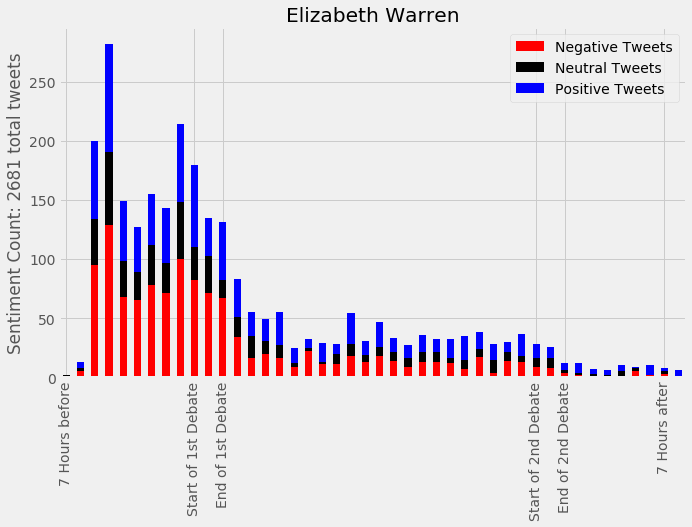

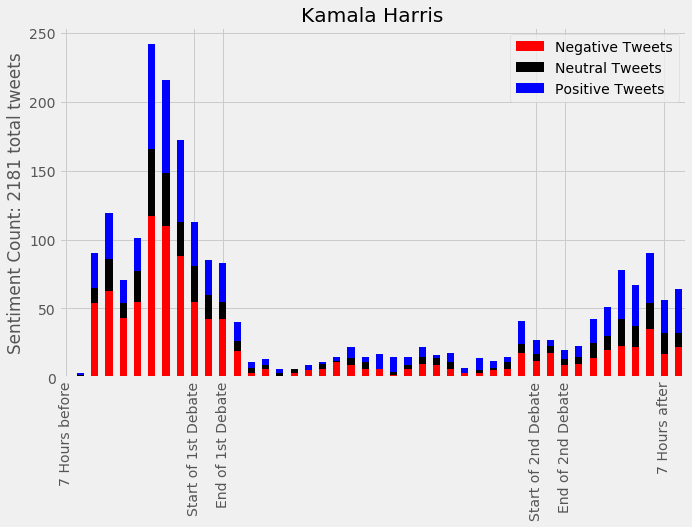

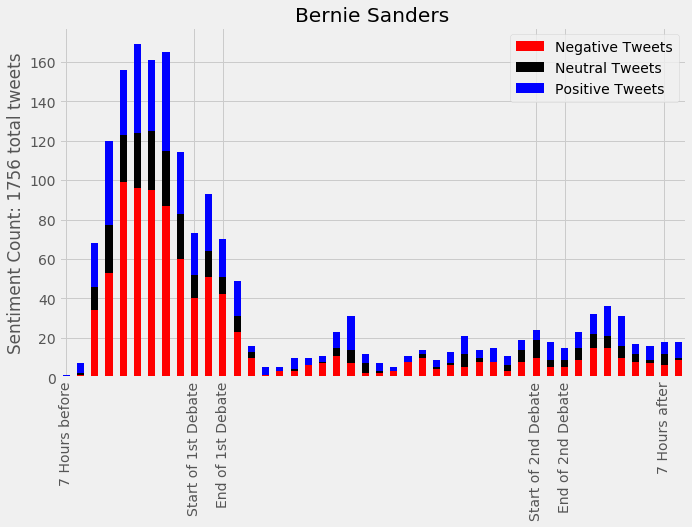

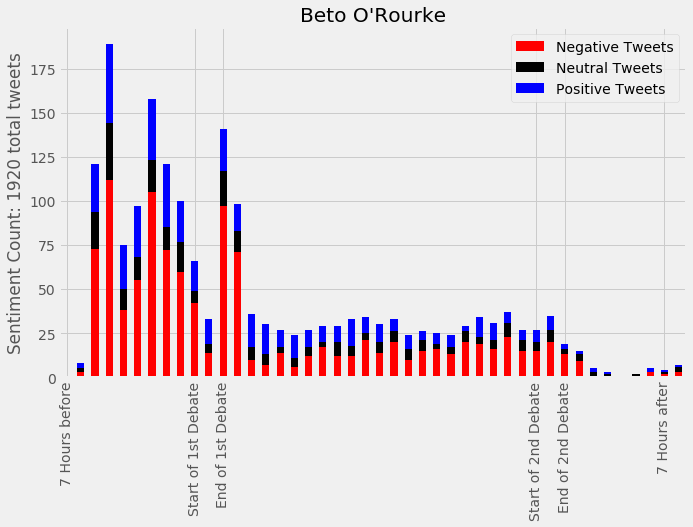

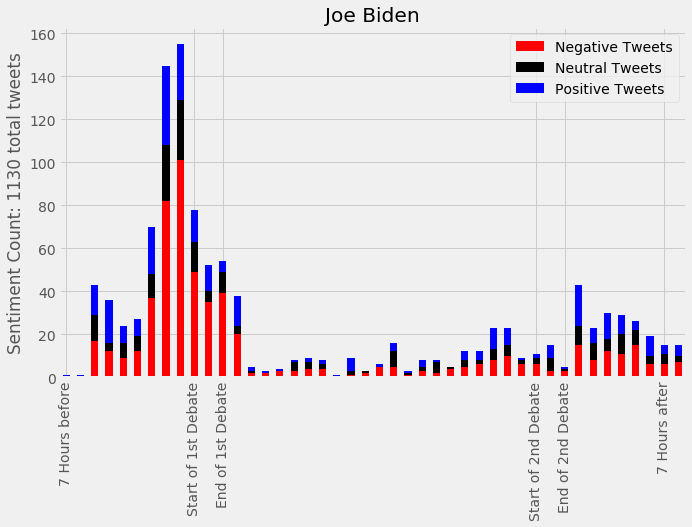

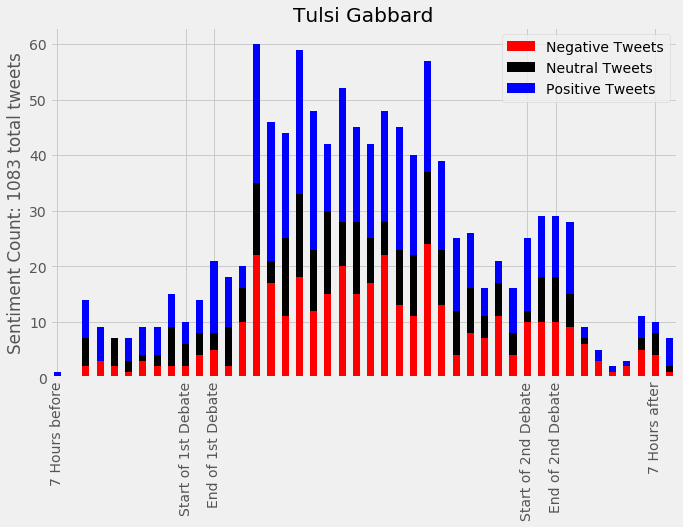

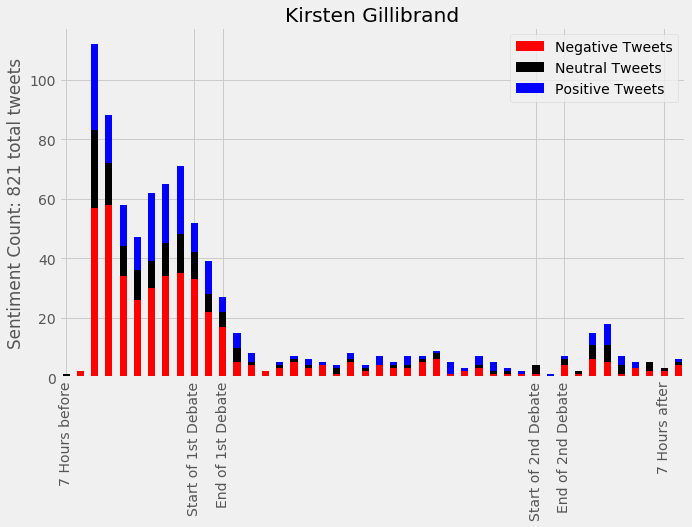

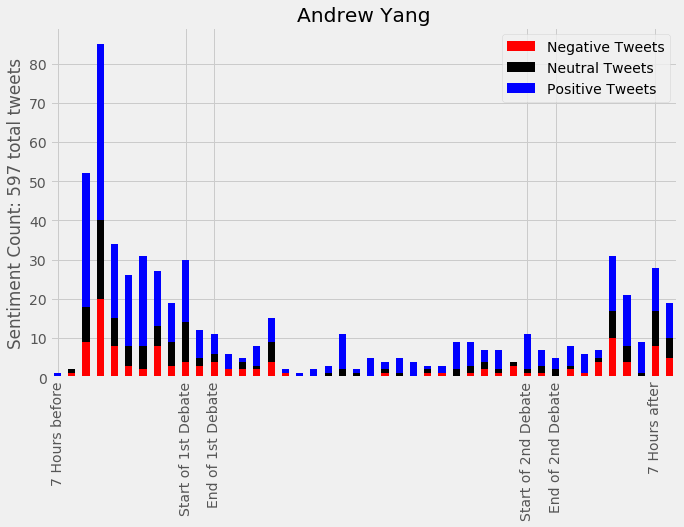

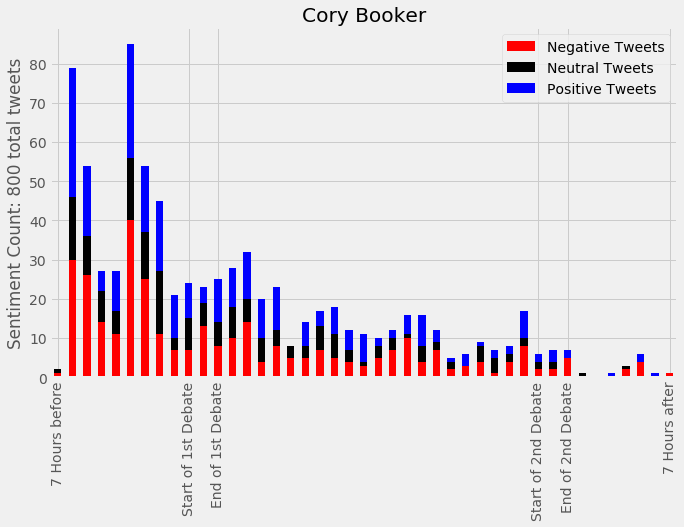

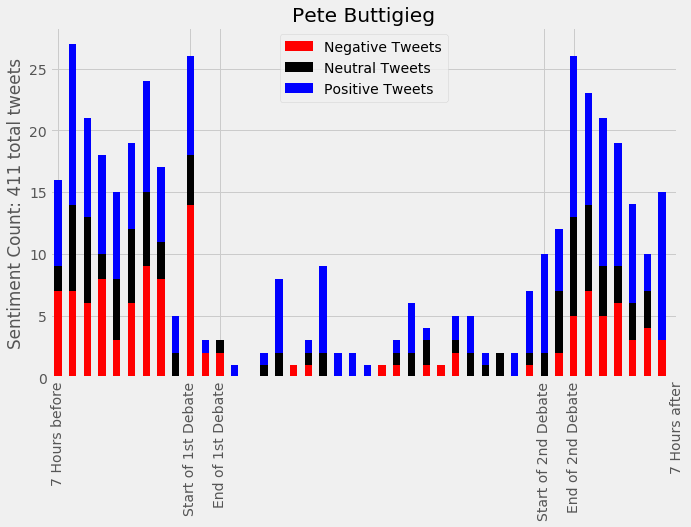

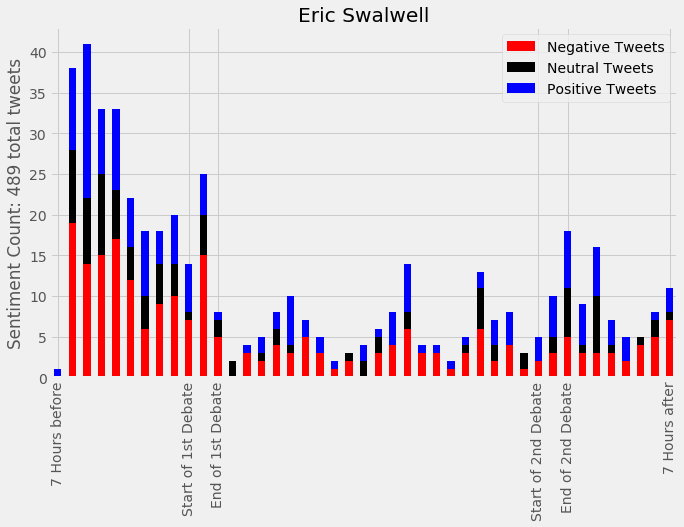

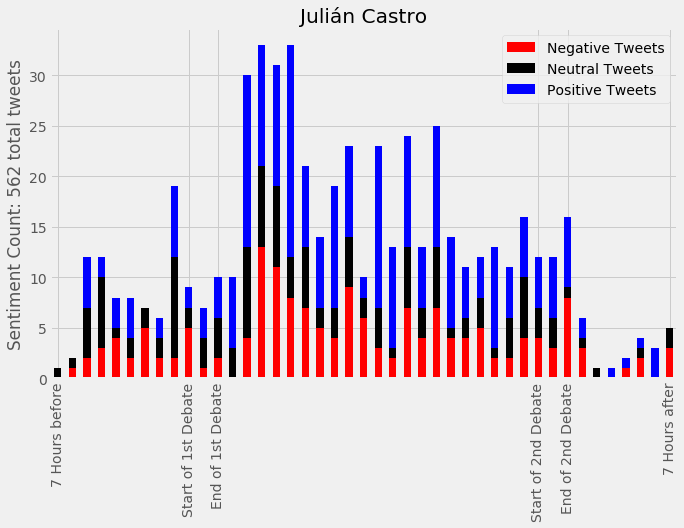

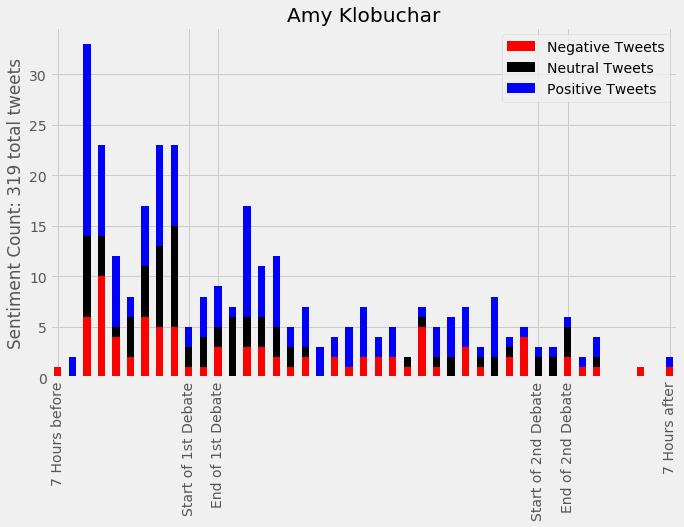

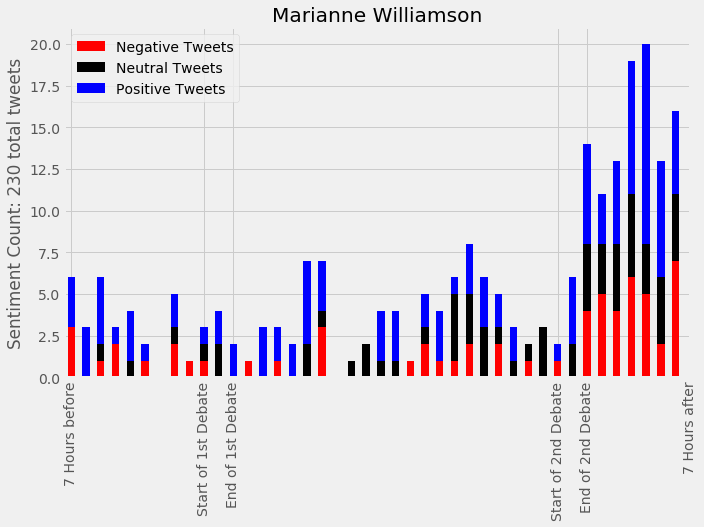

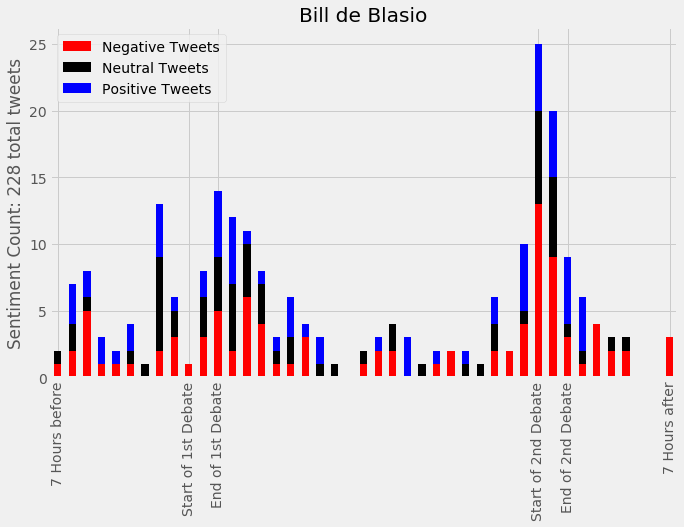

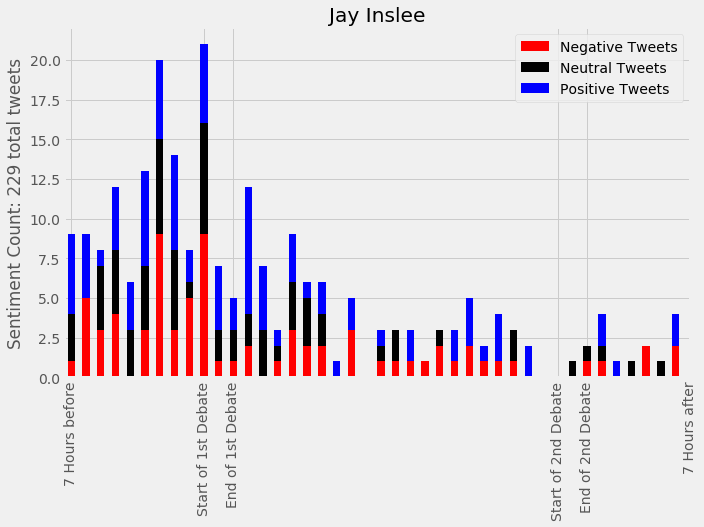

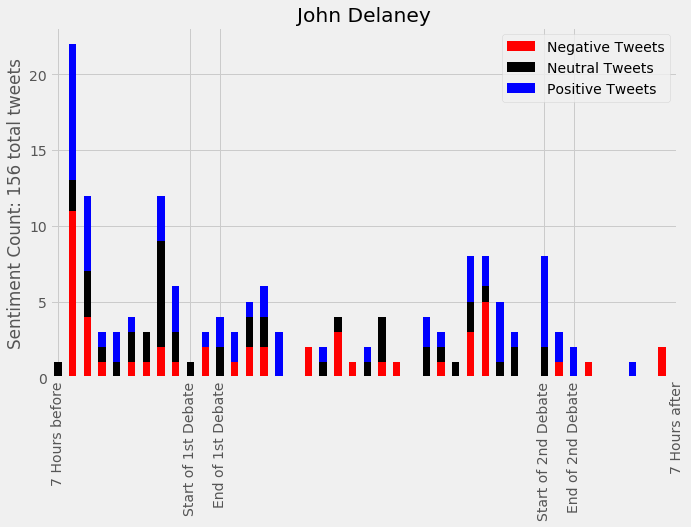

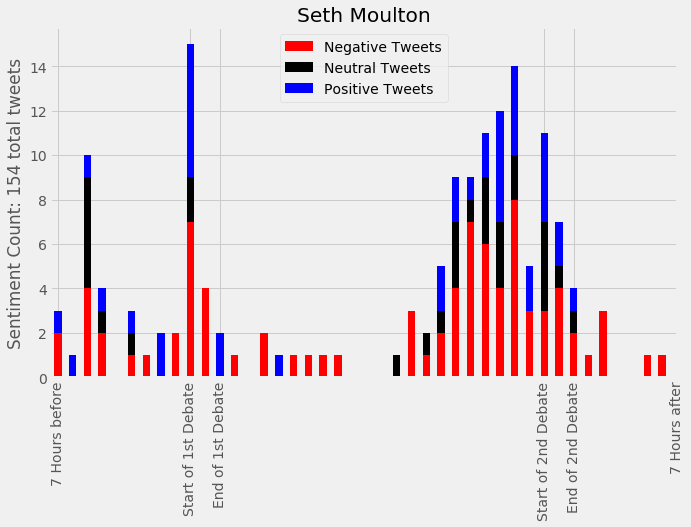

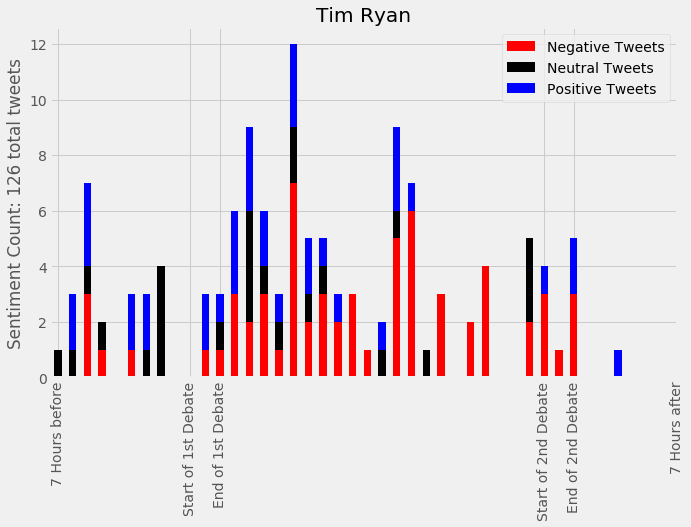

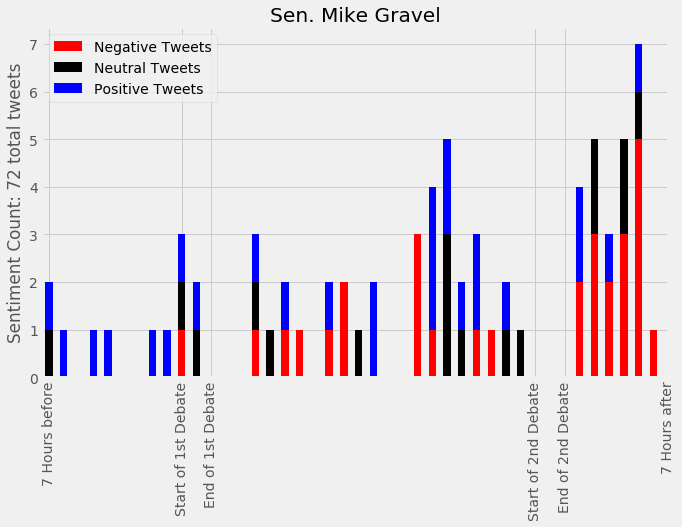

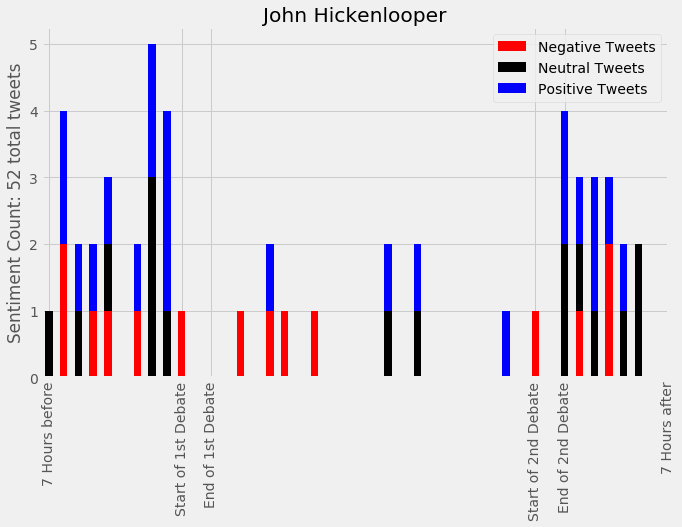

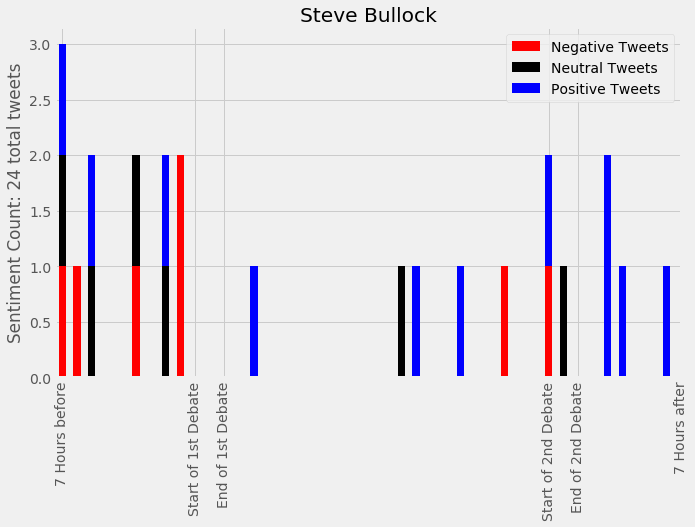

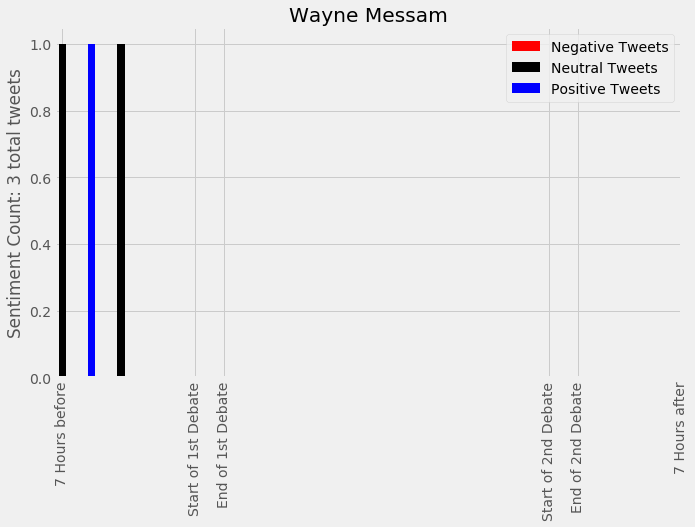

In [121]:
#Create a sentiment plot over time for each candidate
for candidate in s_df.candidate.value_counts().index:
    # Check out the current candidate and the categorical variables
    c_df = s_df[s_df.candidate==candidate][['negative','neutral','positive']]
    # Filter based on analysis timeline
    ct_df = c_df[before_debate<c_df.index]
    ct_df = ct_df[ct_df.index<after_debate]
    # Get total tweet count
    tweet_cnt = len(ct_df)
    # Bin counts hourly
    ct_df = ct_df.resample(('H')).sum()
    # Create a stacked barplot
    ax = ct_df.plot(kind='bar',stacked=True,figsize=(10,6),color=['red','black','blue'])
    # Set ticks to correspond to debate timeline labels
    ax.set_xticks([0,9,11,33,35,42])
    ax.set_xticklabels(
        ('7 Hours before','Start of 1st Debate','End of 1st Debate',
               'Start of 2nd Debate','End of 2nd Debate','7 Hours after'),
                rotation=90)
    plt.title(candidate)
    plt.xlabel('')
    plt.ylabel(f'Sentiment Count: {tweet_cnt} total tweets')
    plt.legend(['Negative Tweets','Neutral Tweets','Positive Tweets'])
    plt.show();

In [111]:
#Retrieve updates on candidate follower counts over time
retweet_sample_query= """
MATCH (c:Candidate)-[:TWEETS]->(:Tweet)<-[rt]-(u:User)
RETURN c.name as candidate, rt.usrFollowerCount as followers, rt.created_at as time
"""
rt_df=graph.run(retweet_sample_query).to_data_frame()

In [112]:
# Set DateTimeIndex for DataFrame
rt_df.set_index(pd.to_datetime(rt_df['time']),inplace=True)

In [115]:
# Drop 3 null rows
rt_df.dropna(inplace=True)

In [122]:
# Make sure everything looks okay
rt_df.head()

,candidate,followers,time
time,,,
2019-06-28 16:35:13,Andrew Yang,440161.0,Fri Jun 28 16:35:13 +0000 2019
2019-06-28 16:34:59,Andrew Yang,440156.0,Fri Jun 28 16:34:59 +0000 2019
2019-06-28 16:30:06,Andrew Yang,440000.0,Fri Jun 28 16:30:06 +0000 2019
2019-06-28 16:29:54,Andrew Yang,439988.0,Fri Jun 28 16:29:54 +0000 2019
2019-06-28 16:29:52,Andrew Yang,439987.0,Fri Jun 28 16:29:52 +0000 2019


## Follower Counts
I am not satisfied with the following analysis and left it out of the final article. Will need to rethink how data is structured to sample on Candidate follower count more frequently.

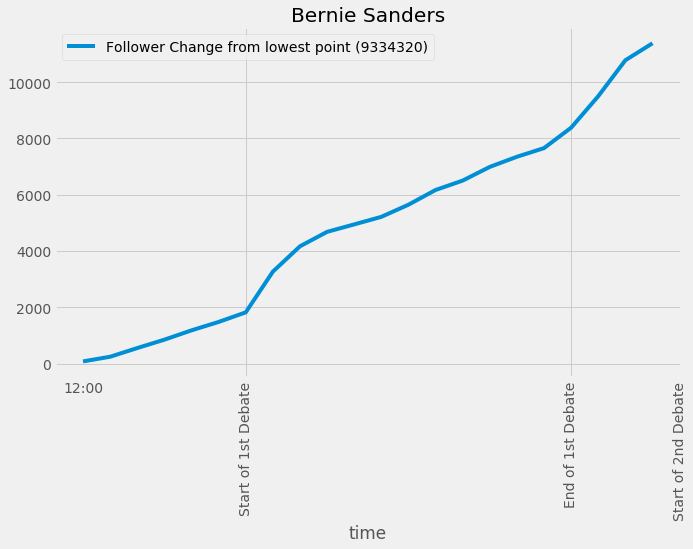

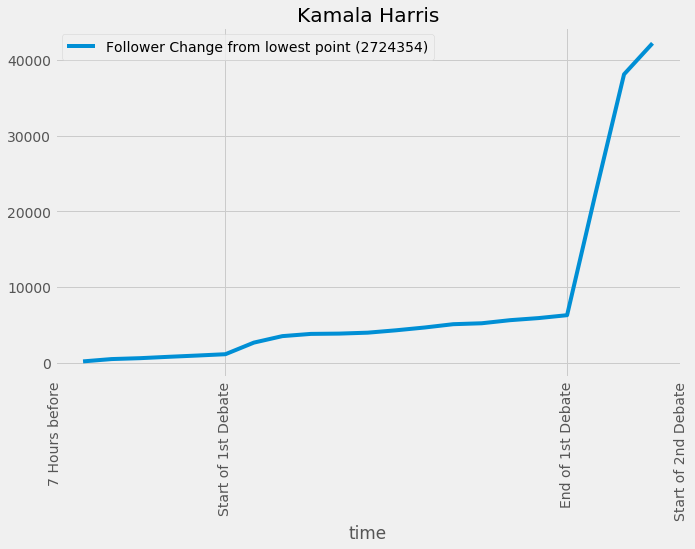

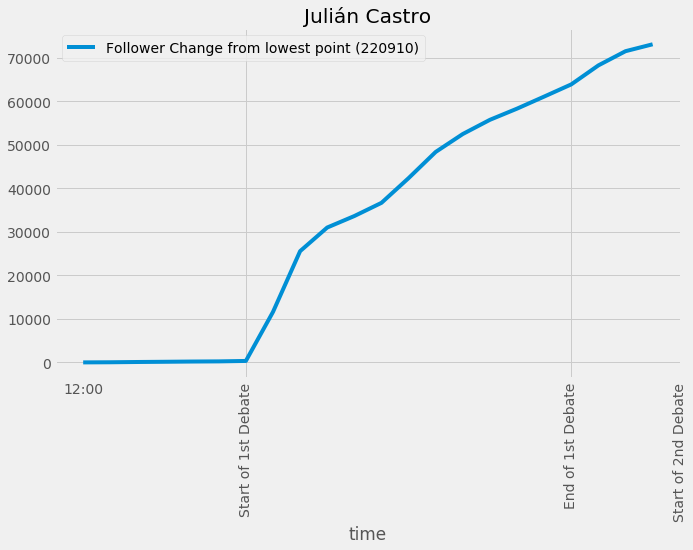

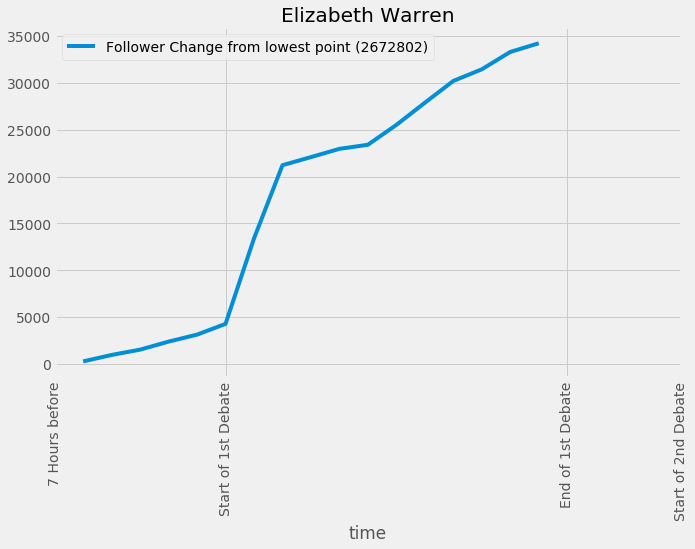

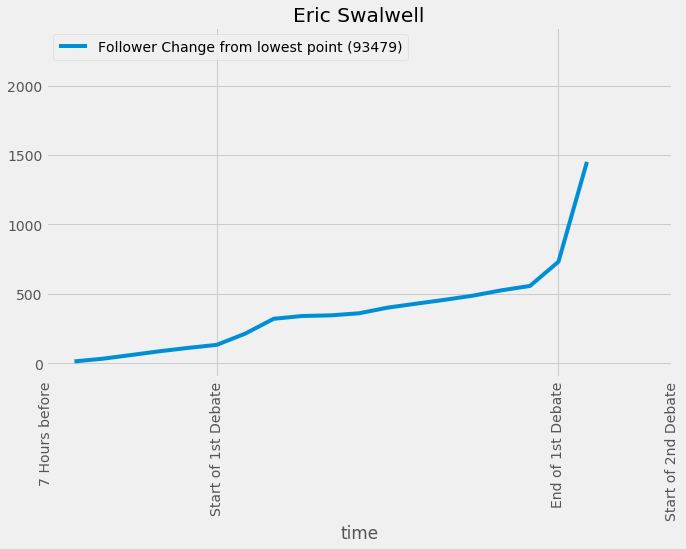

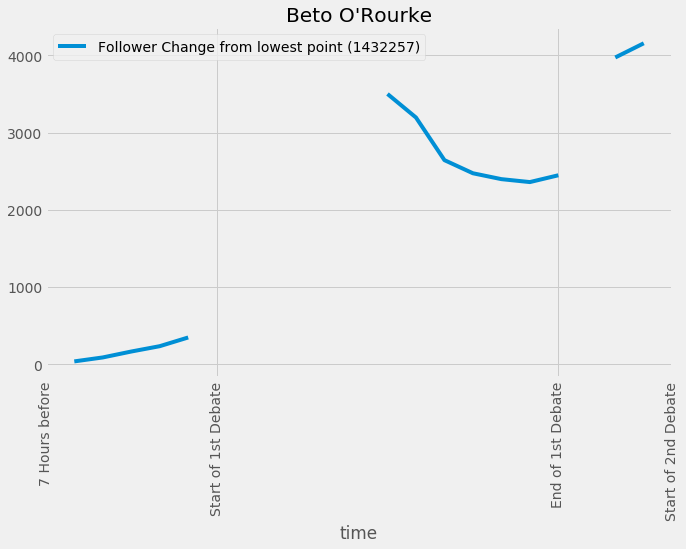

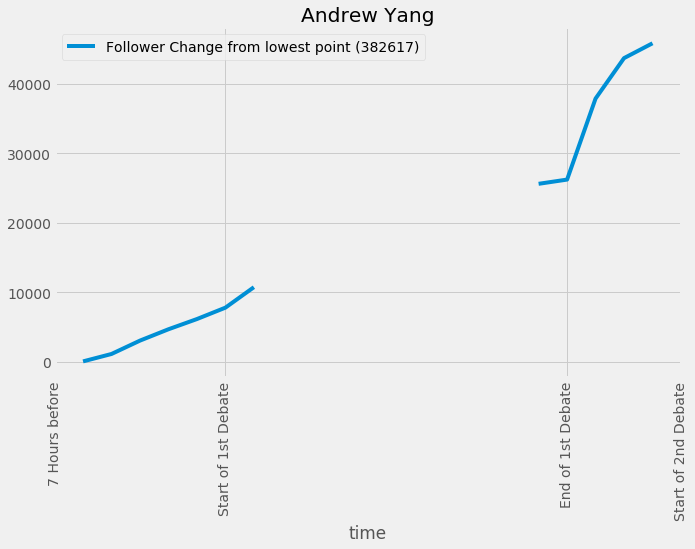

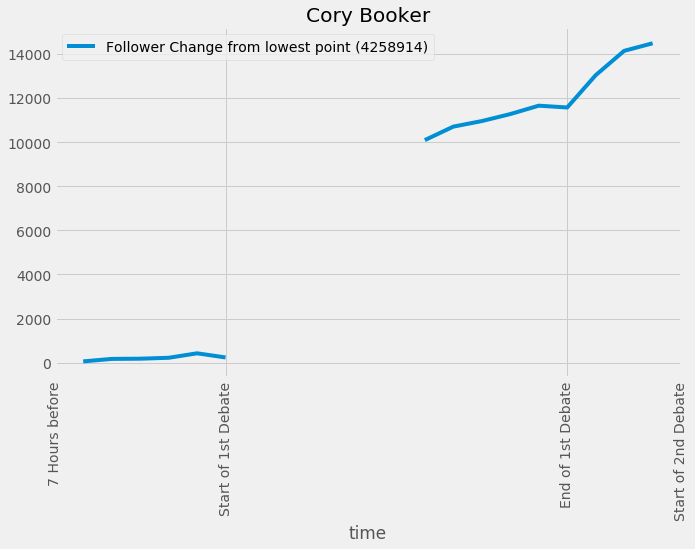

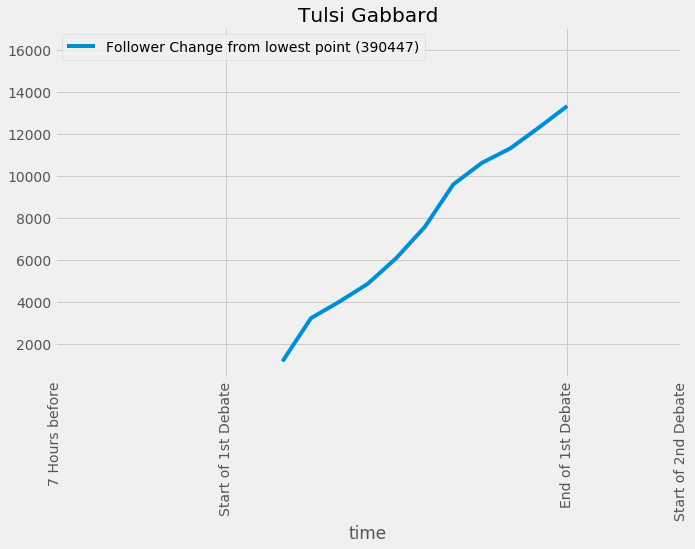

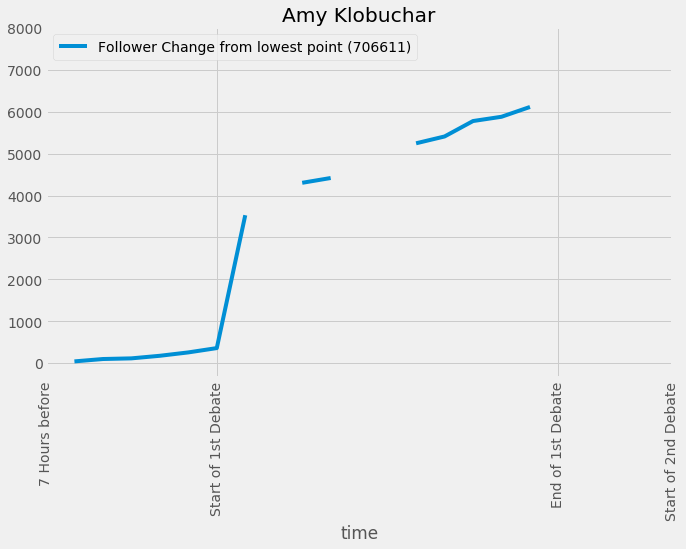

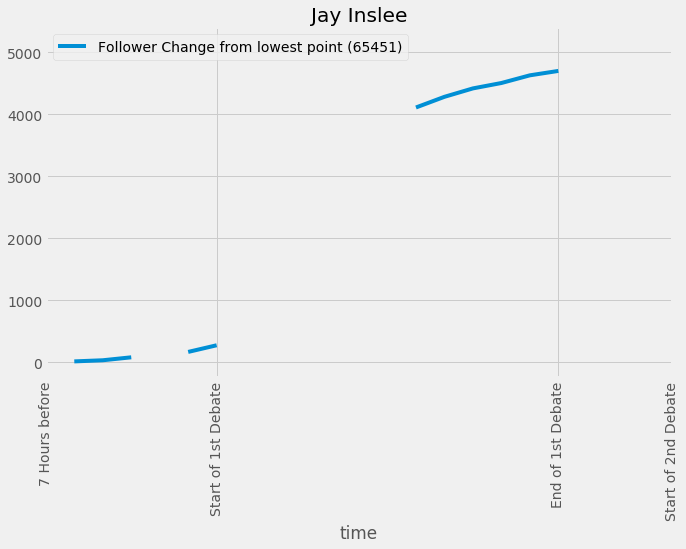

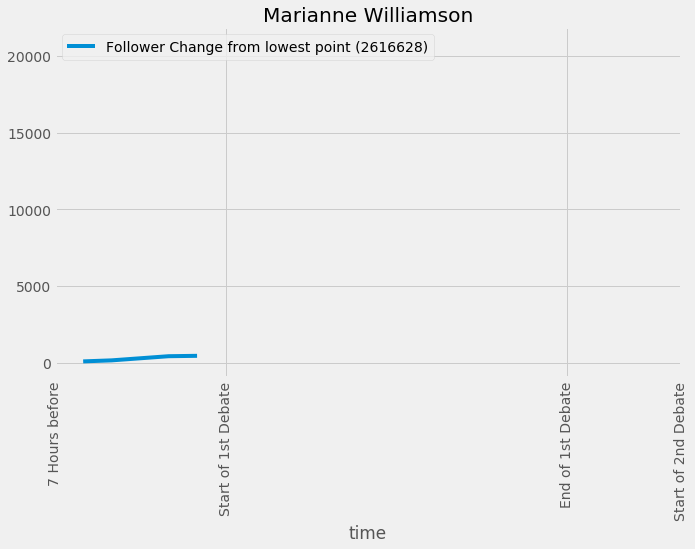

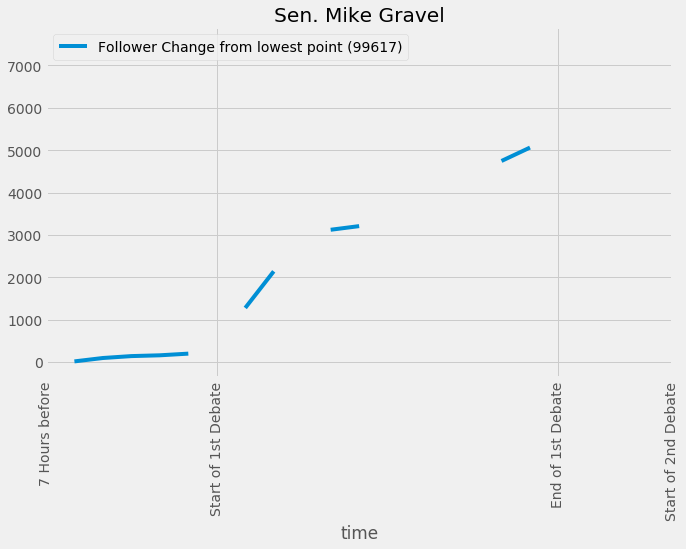

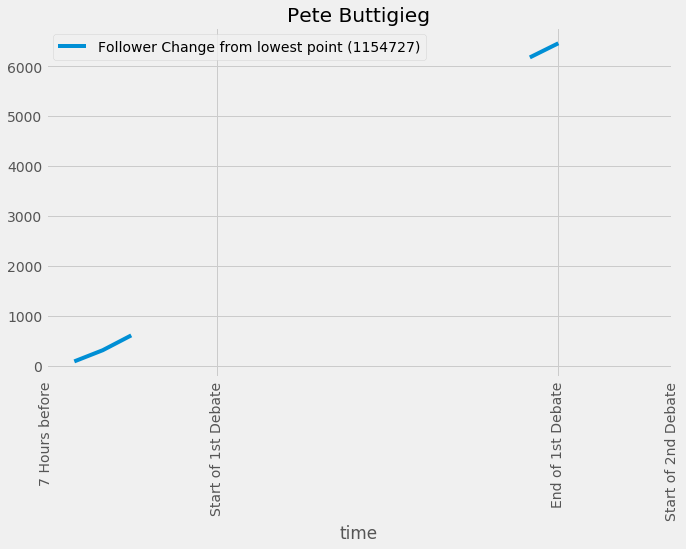

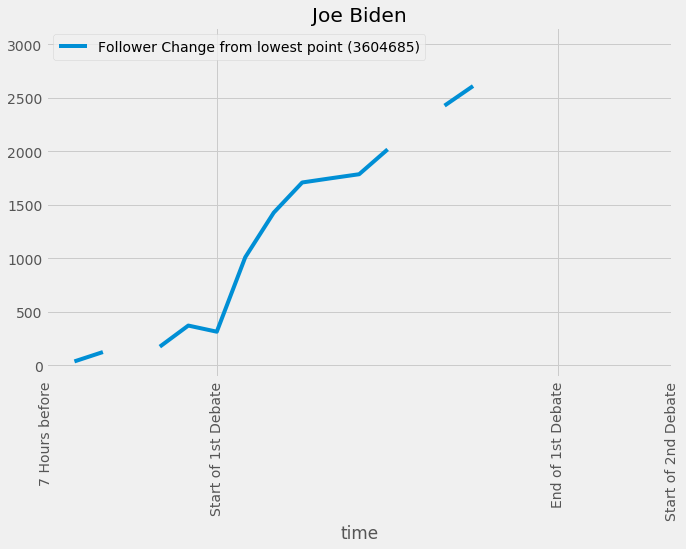

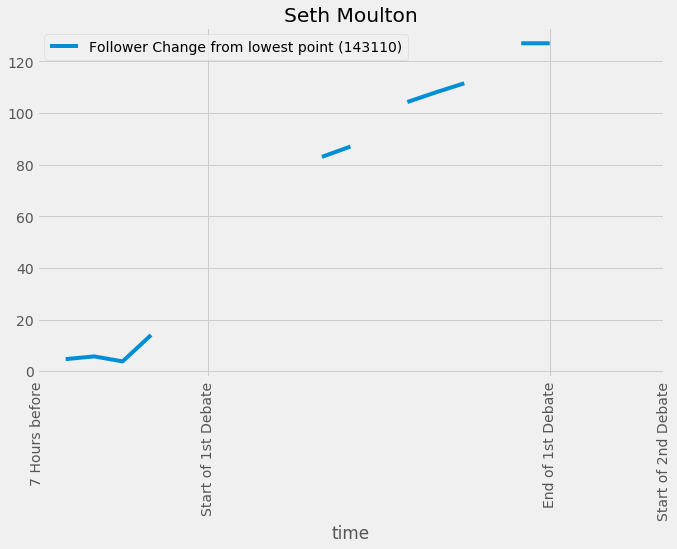

min() arg is an empty sequence
Kirsten Gillibrand failed.


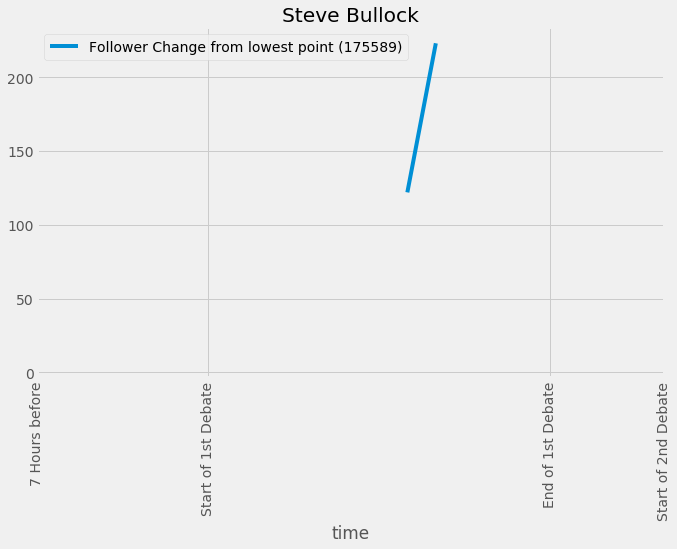

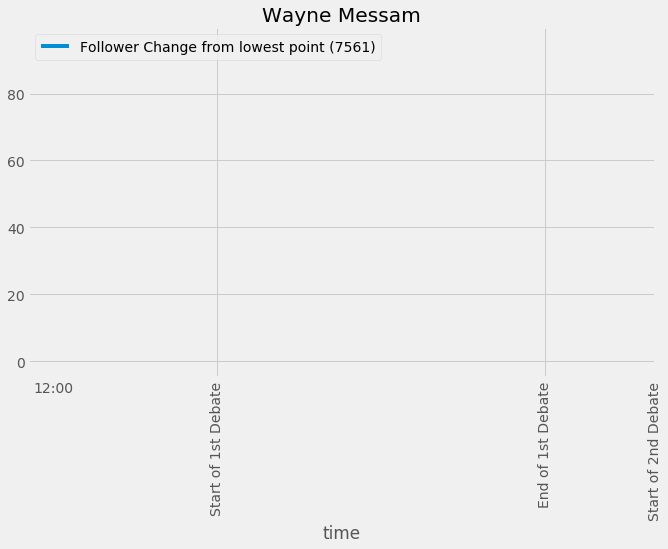

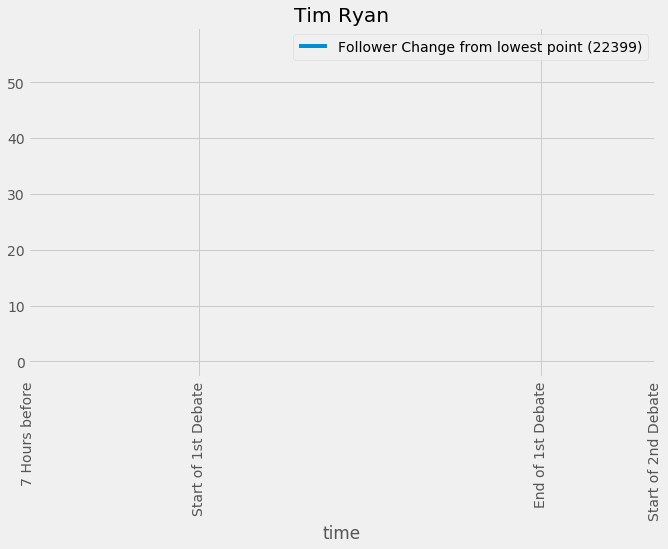

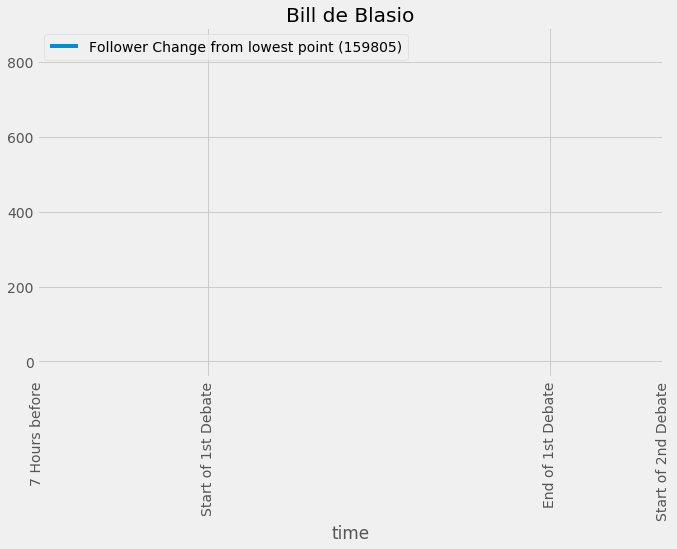

min() arg is an empty sequence
John Delaney failed.


In [119]:
#Create plot showing follower change for each candidate
for candidate in rt_df.candidate.value_counts().index:
    # Check only current candidate and updates within analysis boundaries
    c_df = rt_df[rt_df.candidate==candidate]
    ct_df = c_df[before_debate<c_df.index]
    ct_df = ct_df[ct_df.index<after_debate]
    # Some candidates have no datapoints here, how could that be?
    try: 
        # Get baseline count
        min_f=min(ct_df['followers'])
        # Rescope variable as a difference from baseline
        ct_df['follower_change'] = ct_df['followers'].apply(lambda x: (x-min_f))
        # Sample over two hours to smooth graph
        ct_df = ct_df.resample(('2H')).mean()
        ax = ct_df['follower_change'].plot(figsize=(10,6))
        plt.title(candidate)
        # Set up labels based on debate timeline
        ax.set_xticks(['2019-06-26 12:00:00','2019-06-26 21:00:00','2019-06-26 23:00:00',
                '2019-06-27 21:00:00','2019-06-27 23:00:00','2019-06-28 08:00:00'],
              ('7 Hours before 1st Debate','Start of 1st Debate','End of 1st Debate',
              'Start of 2nd Debate','End of 2nd Debate','7 Hours after 2nd Debate'))
        ax.set_xticklabels(
        ('7 Hours before','Start of 1st Debate','End of 1st Debate',
               'Start of 2nd Debate','End of 2nd Debate','7 Hours after'),
                rotation=90)
        plt.legend([f'Follower Change from lowest point ({int(min_f)})'])
        plt.show();
    except BaseException as e:
        print(e)
        print (f'{candidate} failed.')